In [1]:
# -*- coding:utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class QuantileDQNNet(nn.Module):

    def __init__(self, config):
        super(QuantileDQNNet, self).__init__()
        self.config = config
        self.input_dim = config.input_dim
        self.action_dim = config.action_dim
        self.num_quantiles = config.num_quantiles
        output_dim = self.action_dim * self.num_quantiles

        self.k = config.huber_loss_threshold
        # quantiles, e.g. [0.125, 0.375, 0.625, 0.875]
        self.cum_density = (2 * np.arange(self.num_quantiles) + 1) / (2.0 * self.num_quantiles)
        # append r_0 = 0, [0.   , 0.125, 0.375, 0.625, 0.875]
        temp = np.sort(np.append(self.cum_density, 0))
        # calculate r_hat [0.0625, 0.25, 0.5, 0.75], see lemma 2 in the original paper.
        self.r_hat = np.array([(temp[j] + temp[j - 1]) / 2 for j in range(1, temp.shape[0])])

        self.layer1 = nn.Linear(self.input_dim, 24)
        self.layer2 = nn.Linear(24, output_dim)
        self.reshape_layer = lambda x: x.view(-1, self.action_dim, self.num_quantiles)  # Lambda layer for reshaping

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        x = self.reshape_layer(x)

        # Get action values
        action_values = torch.sum(x, dim=2)
        idx = torch.argmax(action_values, dim=1).to(torch.int64)

        # Get indices for the optimal action quantiles
        idx = idx.view(x.shape[0], 1, 1).expand(-1, -1, self.num_quantiles)
        # idx = torch.stack([torch.arange(action.size(0)), action], dim=1) # This is the version from direct translation
        
        # Extract optimal action quantiles
        optimal_action_quantiles = torch.gather(x, dim=1, index=idx).squeeze(1)
 
        return x, optimal_action_quantiles
    

def huber_loss(mu, k):
    """
    equation 10 of the original paper
    :return:
    """
    #print("INSPECTING #1: ", mu)
    return torch.where(
        torch.abs(mu) < k,
        0.5 * torch.square(mu),
        k * (torch.abs(mu) - 0.5 * k)
    )
    

def quantile_huber_loss(y_true, y_predict, k):
    """
    The loss function that is passed to the network
    see algorithm 1 in the original paper for more details
    :param y_true: true label, quantiles_next, [batch_size, num_quantiles]
    :param y_predict: predicted label, quantiles, [batch_size, num_quantiles]
    :return: quantile huber loss between the target quantiles and the quantiles
    """
    # compute r_hat
    num_quantiles = y_true.shape[1]
    batch_size = y_true.shape[0]
    # taus
    cum_density = (2 * np.arange(num_quantiles) + 1) / (2.0 * num_quantiles)
    # append r_0 = 0, [0.  , 0.125, 0.375, 0.625, 0.875]
    temp = np.sort(np.append(cum_density, 0))
    # calculate r_hat [0.0625, 0.25, 0.5, 0.75], see lemma 2 in the original paper.
    r_hat = np.array([(temp[j] + temp[j - 1]) / 2 for j in range(1, temp.shape[0])])

    batch_loss = torch.zeros(batch_size)
    for each_batch in range(batch_size):
        each_transition_sample_loss = 0
        for i in range(y_true.shape[1]):
            diff = y_true[each_batch] - y_predict[each_batch, i]

            # calculate the expected value over j
            target_loss = torch.mean(
                (huber_loss(diff, k) *
                    torch.abs(r_hat[i] - (diff < 0).to(dtype=torch.float32))))

            # sum over i in algorithm 1
            each_transition_sample_loss += target_loss

        # get batch loss size=(32, 1)
        batch_loss[each_batch] = each_transition_sample_loss
    
    return torch.mean(batch_loss)
    

In [2]:
from src.utils.config import Config
import gym

game = 'CartPole-v1'

env = gym.make(game)
config = Config(env)
Batchsize = 20
x = torch.randn((Batchsize, 4))

net  = QuantileDQNNet(config)

x, actorNet_output_argmax = net(x)

In [4]:
# -*- coding:utf-8 -*-
from src.utils.replay_memory import ReplayMemory, Transition
from src.utils.visualization import plot_durations
from src.utils.reproducibility import set_seed
import torch
import torch.optim as optim
from src.network.QuantileDQN_net import QuantileDQNNet, quantile_huber_loss
from itertools import count
import random
import math

In [5]:
class QuantileDQNAgent:

    def __init__(self, config):
        self.config = config 
        self.input_dim = config.input_dim
        self.action_dim = config.action_dim

        self.n_quantiles = config.num_quantiles
        self.quantile_weights = 1.0 / float(config.num_quantiles)
        self.k = config.huber_loss_threshold

        self.total_steps = 0
        self.num_episodes = config.num_episodes
        self.steps = config.steps
        self.BATCH_SIZE = config.BATCH_SIZE
        self.GAMMA = config.GAMMA
        self.LR = config.LR
        self.TAU = config.TAU
        self.device = config.device
        
        # reproducibility
        self.seed = config.seed 
        set_seed(self.seed)

        self.env = None
        # copying weights of base_net to policy_net and target_net
        self.policy_net = QuantileDQNNet(config)
        self.target_net = QuantileDQNNet(config)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
        self.criterion = quantile_huber_loss

        self.replay_buffer_size = config.replay_buffer_size
        self.replay_memory = ReplayMemory(self.replay_buffer_size)
        
        self.episode_durations = []
        self.check_model_improved = torch.tensor([0])
        self.best_max = torch.tensor([0])

        # for select action (epsilon-greedy)
        self.steps_done = 0
       

    def transition(self):
        """
        In transition, the agent simply plays and records
        [current_state, action, reward, next_state, done]
        in the replay_memory

        Updating the weights of the neural network happens
        every single time the replay buffer size is reached.

        done: boolean, whether the game has ended or not.
        """
        self.env.action_space.seed(self.seed)

        for i_episode in range(self.num_episodes):
            state, info = self.env.reset(seed=self.seed) 
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)

            print('Episode: {} Reward: {} Max_Reward: {}'.format(i_episode, self.check_model_improved[0].item(), self.best_max[0].item()))
            print('-' * 64)
            self.check_model_improved = 0
            
            for t in count():
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = self.env.step(action.item())
                reward = torch.tensor([reward], device=self.device)
                done = terminated or truncated

                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)

                # Store the transition in memory
                self.replay_memory.push(state, action, next_state, reward)

                # Move to the next state
                state = next_state
                self.total_steps += 1

                # Perform one step of the optimization (on the policy network)
                # TODO see how to make differently than in Pytorch tutorial: optimize_model()
                # this is done partly in train_by_replay
                # Note difference in previous implementation -> cleared buffer after replay 
                # and waited until buffer size was reached instead of batch size
                # if len(self.replay_buffer) == self.replay_buffer_size:
                #     self.train_by_replay()
                #     self.replay_buffer.clear()
                self.train_by_replay()

                # Soft update of the target network's weights 
                # θ′ ← τ θ + (1 −τ )θ′
                # previous implementation updates were done for any episode where the reward is higher
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
                self.target_net.load_state_dict(target_net_state_dict)

                if done:
                    self.episode_durations.append(t + 1)
                    #plot_durations(self)
                    break
                else:
                    self.check_model_improved += reward

            if self.check_model_improved > self.best_max:
                self.best_max = self.check_model_improved


    def train_by_replay(self):
        """
        TD update by replaying the history.
        """
        # step 1: generate replay samples (size = self.batch_size) from the replay buffer
        # e.g. uniform random replay or prioritize experience replay
        if len(self.replay_memory) < self.BATCH_SIZE:
            return
        transitions = self.replay_memory.sample(self.BATCH_SIZE)

        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        _, optimal_action_quantiles = self.policy_net(state_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        quantiles_next = torch.zeros(self.BATCH_SIZE, self.action_dim, self.n_quantiles, device=self.device)
        with torch.no_grad():
            quantiles_next[non_final_mask], _ = self.target_net(non_final_next_states)

        action_value_next = torch.sum(quantiles_next, dim=2)
        idx = torch.argmax(action_value_next, dim=1).to(torch.int64)
        #print("DEBUG #1:", idx.shape)

        quantiles_next = quantiles_next[torch.arange(self.BATCH_SIZE), idx, :]

        # match the rewards from the memory to the same size as prob_next
        reshaped_reward_batch = torch.tile(reward_batch.reshape(self.BATCH_SIZE, 1), (1, self.n_quantiles))

        # perform TD update 
        discount = torch.tile((self.GAMMA * non_final_mask).reshape(self.BATCH_SIZE, 1), (1, self.n_quantiles))

        # TD update
        quantiles_next = reshaped_reward_batch + discount * quantiles_next

        # Compute Huber loss 
        loss = self.criterion(optimal_action_quantiles, quantiles_next, self.k)

        # Optimize the model
        self.optimizer.zero_grad()

        # DEBUGGIING to find which tensor isn't tracked by the computation graph 
        #print("DEBUG #2:", loss.requires_grad, loss.grad_fn)

        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()


    def eval_step(self, render=True):
        """
        Evaluation using the trained target network, no training involved
        :param render: whether to visualize the evaluation or not
        """
        for each_ep in range(self.config.evaluate_episodes):
            state, info = self.env.reset(seed=self.seed) 
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)

            print('Episode: {} Reward: {} Training_Max_Reward: {}'.format(each_ep, self.check_model_improved[0].item(),
                                                                          self.best_max[0].item()))
            print('-' * 64)
            self.check_model_improved = 0

            for t in count():
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = self.env.step(action.item())
                reward = torch.tensor([reward], device=self.device)
                done = terminated or truncated 

                if render:
                    self.env.render()

                if done:
                    break
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)  
                    state = next_state
                    self.check_model_improved += reward
        
        print('Complete')


    # NOTE Create an abstract class of Agents with this method
    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.config.EPS_END + (self.config.EPS_START - self.config.EPS_END) * \
            math.exp(-1. * self.steps_done / self.config.EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # size = (1, action dimension, num_quantiles)
                action_quantiles, _ = self.policy_net(state)
                action_values = torch.sum(action_quantiles, dim=2)

                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                max_actions = action_values.max(1).indices.view(1, 1)
                return max_actions
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)

In [6]:
def moving_average(time_series, window_size=20):
    # Initialize the list with zeros for the first 100 elements
    averaged_series = [0] * min(window_size, len(time_series))
    
    # Compute the moving average for each position in the series
    for i in range(window_size, len(time_series)):
        # Calculate the average of the last 100 elements from the current position
        average = (sum(time_series[i-window_size:i]) / window_size)
        if type(average) != type(0.0):
            average = average[0]
        averaged_series.append(average)
    
    return averaged_series

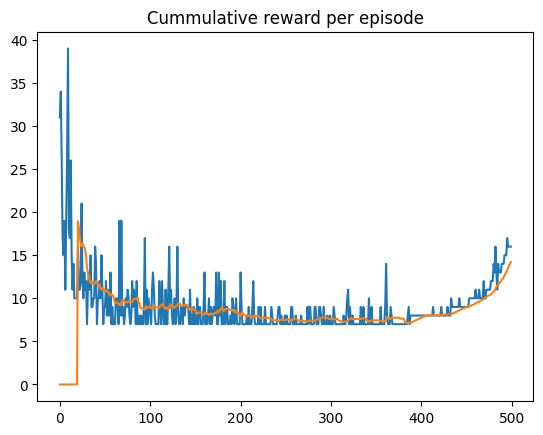

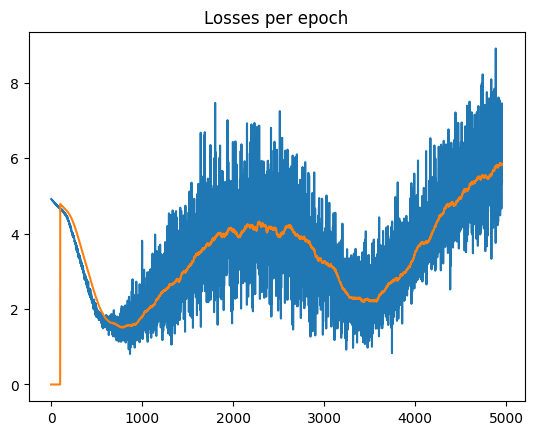

In [15]:
import numpy as np
import matplotlib.pyplot as plt

rewards = np.load("rewards_QDRL.npy")
losses = np.load("losses_QDRL.npy").tolist()
# unpacking the elements of losses that are numpy arrays
#losses = [loss[0] for loss in losses]

reward_average = moving_average(rewards)
loss_average = moving_average(losses, window_size=100)

plt.plot(rewards)
plt.plot(reward_average)
plt.title("Cummulative reward per episode")
plt.show()

plt.plot(losses)
plt.plot(loss_average)
plt.title("Losses per epoch")
plt.show()